In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import data
from data import en_chset, ko_chset_cho, ko_chset_jung, ko_chset_jong
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

print("packs loaded")
%connect_info

packs loaded
{
  "kernel_name": "",
  "control_port": 47973,
  "signature_scheme": "hmac-sha256",
  "ip": "127.0.0.1",
  "stdin_port": 45915,
  "hb_port": 60977,
  "transport": "tcp",
  "key": "3c5feff9-748c-48d7-98ac-57fca9771f5b",
  "iopub_port": 58001,
  "shell_port": 56801
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-41ba424a-e845-42b8-a4de-0e5ac1e6d863.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
index_data, img, label = data.get_all()

index loaded
tar opened
 0% complete (1 / 7920)
image loaded
index loaded
tar opened
 0% complete (1 / 21150)
47% complete (10001 / 21150)
95% complete (20001 / 21150)
image loaded
label loaded
shuffled


In [23]:
class BatchBuffer:
    def __init__(self, offset, size):
        self.offset = offset
        self.size = size
        self.index = 0
    
    def read(self, num=None):
        raise NotImplementedError('Unimplemented')
        
    def seek(self, num, mode=0):
        if mode == 0:
            self.index = self.offset+num
        elif mode == 1:
            self.index += num
        elif mode == 2:
            self.index = self.offset+self.size+num
        else:
            raise NotImplementedError('Unimplemented')
        
    def tell(self):
        return self.index

class ArrayBuffer(BatchBuffer):
    def __init__(self, array, offset, size):
        if size < 0:
            size = len(array) - offset
        super().__init__(offset, size)
        self.array = array
    
    def read(self, num=None):
        if self.index >= self.size:
            return -1
        
        if num is None:
            num = self.size - self.index
            
        ni = self.index+num
        if ni >= self.size:
            ni = self.size
        ret = self.array[self.offset+self.index:self.offset+ni-1]
        self.index += num
        return ret

trainimg = ArrayBuffer(img, 15000, -1)
trainlabel = ArrayBuffer(label, 15000, -1)
testimg = ArrayBuffer(img, 0, 12000)
testlabel = ArrayBuffer(label, 0, 12000)
cvimg = ArrayBuffer(img, 12000, 3000)
cvlabel = ArrayBuffer(label, 12000, 3000)
randidx = np.random.randint(trainimg.size, size=2)

(29070, 32, 32)
{'font': 'Batang', 'target': '앵', 'path': '0012398.png', 'weight': 'NORMAL'}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
15000
14070
15000
-1


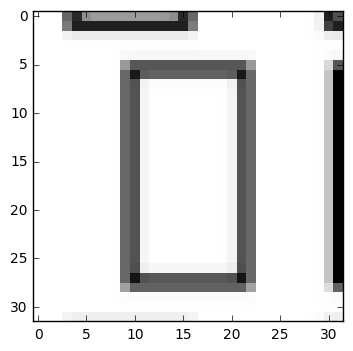

In [22]:
print(img.shape)
plt.figure()
plt.imshow(img[0], interpolation='none')
print(index_data[0])
print(label[0])

trainlabel.seek(0)
print(trainlabel.offset)
print(trainlabel.size)
print(trainlabel.index)
print(trainlabel.read(3))

In [21]:
def flatten_cnn(layer):
    layer_shape = layer.get_shape().as_list()
    n_out = layer_shape[1] * layer_shape[2] * layer_shape[3]
    return tf.reshape(layer, [-1, n_out])

def build_nn(shape, X, name):
    n_before = int(X.get_shape()[1])
    W = tf.Variable(tf.truncated_normal([n_before, shape], stddev=0.1), name=name+"_W")
    b = tf.Variable(tf.constant(0.1, shape=[shape]), name=name+"_b")
    return tf.matmul(X, W)+b

def build_cnn(cnn_shape, patch_shape, X, name, stride=1):
    n_before = int(X.get_shape()[3])
    W = tf.Variable(tf.truncated_normal([patch_shape[0], patch_shape[1], n_before, cnn_shape], stddev=0.1),
                   name=name+"_W")
    b = tf.Variable(tf.constant(0.1, shape=[cnn_shape]), name=name+"_b")
    layer = tf.nn.relu(tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME') + b)
    return layer

def max2d_pool(layer):
    return tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def slice_label(tf_label, len_tuple):
    cur = 0
    sliced = []
    for l in len_tuple:
        sliced.append(tf.slice(tf_label, [0, cur], [-1, l]))
        cur += l
    return tuple(sliced)

print("function loaded")

function loaded


In [22]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32])
Y = tf.placeholder(tf.float32, [None, 160])
keep_prob = tf.placeholder(tf.float32)

Y_cho, Y_jung, Y_jong, Y_en = slice_label(Y,
                                         (len(ko_chset_cho)+1,
                                         len(ko_chset_jung)+1,
                                         len(ko_chset_jong)+1,
                                         len(en_chset)+1))
# Small inception model
# http://laonple.blog.me/220704822964
X_reshape = tf.reshape(X, [-1, 32, 32, 1])
cnn_1_5 = build_cnn(12, [5,5], X_reshape, "cnn_1_5")
cnn_1_3 = build_cnn(36, [3,3], X_reshape, "cnn_1_3")
cnn_1_concat = tf.concat(3, [cnn_1_5, cnn_1_3])
cnn_1_pool = max2d_pool(cnn_1_concat) # 16 * 16 * 48

cnn_2_5 = build_cnn(18, [5,5], cnn_1_pool, "cnn_2_5")
cnn_2_3 = build_cnn(48, [3,3], cnn_1_pool, "cnn_2_3")
cnn_2_1 = build_cnn(30, [1,1], cnn_1_pool, "cnn_2_1")
cnn_2_concat = tf.concat(3, [cnn_2_5, cnn_2_3, cnn_2_1])
cnn_2_pool = max2d_pool(cnn_2_concat) # 8 * 8 * 96

cnn_3_5_reduce = build_cnn(18, [1,1], cnn_2_pool, "cnn_3_5_reduce")
cnn_3_5 = build_cnn(36, [5,5], cnn_3_5_reduce, "cnn_3_5")
cnn_3_3_reduce = build_cnn(64, [1,1], cnn_2_pool, "cnn_3_3_reduce")
cnn_3_3 = build_cnn(96, [3,3], cnn_3_3_reduce, "cnn_3_3")
cnn_3_1 = build_cnn(60, [1,1], cnn_2_pool, "cnn_3_1")
cnn_3_concat = tf.concat(3, [cnn_3_5, cnn_3_3, cnn_3_1])
cnn_3_pool = max2d_pool(cnn_3_concat) # 4 * 4 * 192

dense_1 = tf.nn.relu(build_nn(1024, flatten_cnn(cnn_3_pool), "dense_1"))
dropout_1 = tf.nn.dropout(dense_1, keep_prob)

logit = build_nn(160, dropout_1, "logit")
logit_cho, logit_jung, logit_jong, logit_en = slice_label(logit,
                                         (len(ko_chset_cho)+1,
                                         len(ko_chset_jung)+1,
                                         len(ko_chset_jong)+1,
                                         len(en_chset)+1))
h_cho = tf.nn.softmax(logit_cho)
h_jung = tf.nn.softmax(logit_jung)
h_jong = tf.nn.softmax(logit_jong)
h_en = tf.nn.softmax(logit_en)

learning_rate = tf.placeholder(tf.float32)
cost_cho = tf.nn.softmax_cross_entropy_with_logits(logit_cho, Y_cho)
cost_jung = tf.nn.softmax_cross_entropy_with_logits(logit_jung, Y_jung)
cost_jong = tf.nn.softmax_cross_entropy_with_logits(logit_jong, Y_jong)
cost_en = tf.nn.softmax_cross_entropy_with_logits(logit_en, Y_en)
cost = cost_cho + cost_jung * 1.5 + cost_jong * 0.5 + cost_en
cost_mean = tf.reduce_mean(cost) # mean of batch set

var_before_adam = tf.all_variables()

train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_cho = tf.equal(tf.argmax(Y_cho,1), tf.argmax(h_cho,1))
correct_jung = tf.equal(tf.argmax(Y_jung,1), tf.argmax(h_jung,1))
correct_jong = tf.equal(tf.argmax(Y_jong,1), tf.argmax(h_jong,1))
correct_two = tf.logical_or(tf.logical_and(correct_cho, tf.logical_or(correct_jung, correct_jong)),
                           tf.logical_and(correct_jung, correct_jong))
correct_ko = tf.logical_and(tf.logical_and(correct_cho, correct_jung), correct_jong)
correct_en = tf.equal(tf.argmax(Y_en,1), tf.argmax(h_en,1))
correct_all = tf.logical_and(correct_ko, correct_en)
accuracy = tf.reduce_mean(tf.cast(correct_all, tf.float32))
accuracy_two = tf.reduce_mean(tf.cast(correct_two, tf.float32))
accuracy_cho = tf.reduce_mean(tf.cast(correct_cho, tf.float32))
accuracy_jung = tf.reduce_mean(tf.cast(correct_jung, tf.float32))
accuracy_jong = tf.reduce_mean(tf.cast(correct_jong, tf.float32))
accuracy_ko = tf.reduce_mean(tf.cast(correct_ko, tf.float32))
accuracy_en = tf.reduce_mean(tf.cast(correct_en, tf.float32))

sess = tf.Session()
for v in var_before_adam:
    print (v.name)
print("session loaded")

cnn_1_5_W:0
cnn_1_5_b:0
cnn_1_3_W:0
cnn_1_3_b:0
cnn_2_5_W:0
cnn_2_5_b:0
cnn_2_3_W:0
cnn_2_3_b:0
cnn_2_1_W:0
cnn_2_1_b:0
cnn_3_5_reduce_W:0
cnn_3_5_reduce_b:0
cnn_3_5_W:0
cnn_3_5_b:0
cnn_3_3_reduce_W:0
cnn_3_3_reduce_b:0
cnn_3_3_W:0
cnn_3_3_b:0
cnn_3_1_W:0
cnn_3_1_b:0
dense_1_W:0
dense_1_b:0
logit_W:0
logit_b:0
session loaded


In [25]:
def init_session():
    sess.run(tf.initialize_all_variables())
    print("session initialized")

def get_accuracy_no_batch(imgset, labelset):
    return sess.run((accuracy, accuracy_cho, accuracy_jung, accuracy_jong, accuracy_two, accuracy_en),
                                        feed_dict={X:imgset, Y:labelset, keep_prob:1})

def get_accuracy(imgbuf, labelbuf, batch=True):
    imgbuf.seek(0)
    labelbuf.seek(0)
    
    if batch:
        temp_tuple = 0, 0, 0, 0, 0, 0
        i = 0
        while(True):
            batch_x = imgbuf.read(100)
            batch_y = labelbuf.read(100)
            temp_tuple = tuple([item1 + item2 * batch_x.shape[0] for item1, item2 in
                                zip(temp_tuple,
                                    get_accuracy_no_batch(batch_x, batch_y))])
            i += batch_x.shape[0]
        tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = tuple([item / i for item in temp_tuple])
    else:
        tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = get_accuracy_no_batch(imgbuf.read(), labelbuf.read())
    return tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en
    
def print_accuracy(imgbuf, labelbuf, batch=True):
    tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = get_accuracy(imgbuf, labelbuf, batch)
    print ("overall accuracy = %.3f                          " % tacc)
    print ("two of three = %.3f" % tacc_two)
    print ("cho = %.3f" % tacc_cho)
    print ("jung = %.3f" % tacc_jung)
    print ("jong = %.3f" % tacc_jong)
    print ("en = %.3f" % tacc_en)

def do_training(is_console=False, lr_init = 0.003):
    trainsize = trainimg.size
    batchsize = 100
    batch_per_epoch = int(trainsize/batchsize)
    print ("Training %d, mini-batch %d * %d" % (trainsize, batchsize, batch_per_epoch))
    epoch = 0

    i = 0
    lr = lr_init
    while (epoch < 5):
        if i % 200 == 0 :
            tacc = get_accuracy(cvimg, cvlabel, True)[0]
            print ("%6dth epoch : cv accuracy = %.3f                  " % (epoch, tacc))

        batch_x = trainimg.read(batchsize)
        batch_y = trainlabel.read(batchsize)
        
        if batch_x == -1:
            print_accuracy(testimg, testlabel, True)
            trainimg.seek(0)
            trainlabel.seek(0)
            epoch += 1
            continue
        
        cur_cost = sess.run((train, cost_mean), feed_dict={X:batch_x, Y:batch_y, keep_prob:0.5, learning_rate:lr})[1]
        if(is_console):
            print ("%dth... lr = %.2e, cost = %.2e\r" % (i, lr, cur_cost), end="")
        lr = lr * (1 - 0.0003)
        i += 1
        
    print("train complete--------------------------------")
    print("test accuracy ---")
    print_accuracy(testimg, testlabel, True)
    print("train accuracy ---")
    print_accuracy(trainimg, trainlabel, True)
    
def error_check(chset, pred_tf, label_tf, imgbuf, labelbuf):
    label_len = label_tf.get_shape()[1]
    n_error = np.zeros([label_len, label_len])
    n_all = np.zeros(label_len)
    new_chset = chset + ["inv"]
    
    batchsize = 100
    
    imgbuf.seek(0)
    labelbuf.seek(0)
    while(True):
        batch_x = imgbuf.read(batchsize)
        batch_y = labelbuf.read(batchsize)
        if batch_x == -1:
            break
        batchsize = batch_x.shape[0]
        h, y = sess.run((pred_tf, label_tf), feed_dict={X:batch_x, Y:batch_y, keep_prob:1})
        for j in range(batchsize):
            n_all[np.argmax(y[j])] += 1
            if (np.argmax(h[j]) != np.argmax(y[j])):
                n_error[np.argmax(y[j])][np.argmax(h[j])] += 1

    print ("Error rate")
    for i, ch in enumerate(new_chset):
        most_error = np.argmax(n_error[i])
        print ("%s : %2.0f%% (%4d / %4d)" %
               (ch, float(np.sum(n_error[i])) / n_all[i] * 100, np.sum(n_error[i]), n_all[i]), end="")
        if n_error[i][most_error] > 0:
            print ("%6d errors with %s" % (n_error[i][most_error], new_chset[most_error]))
        else:
            print ("")
            
def save_ckpt(path):
    saver = tf.train.Saver(var_before_adam)
    saver.save(sess, path)
    print("ckpt saved")
    
def load_ckpt(path):
    saver = tf.train.Saver(var_before_adam)
    saver.restore(sess, path)
    print("ckpt loaded")
            
print("tf function loaded")

tf function loaded


In [45]:
print_accuracy(testimg, testlabel, True)

overall accuracy = 0.997                          
two of three = 1.000
cho = 1.000
jung = 0.999
jong = 1.000
en = 0.999


In [46]:
error_check(en_chset, h_en, Y_en, testimg, testlabel)

Error rate
0 :  0% (   0 /   34)
1 :  0% (   0 /   28)
2 :  0% (   0 /   39)
3 :  0% (   0 /   34)
4 :  0% (   0 /   38)
5 :  0% (   0 /   45)
6 :  0% (   0 /   40)
7 :  0% (   0 /   29)
8 :  0% (   0 /   47)
9 :  0% (   0 /   37)
a :  0% (   0 /   35)
b :  0% (   0 /   44)
c :  0% (   0 /   40)
d :  0% (   0 /   45)
e :  0% (   0 /   33)
f :  0% (   0 /   33)
g :  0% (   0 /   30)
h :  0% (   0 /   36)
i :  3% (   1 /   39)     1 errors with I
j :  0% (   0 /   44)
k :  0% (   0 /   40)
l : 20% (   6 /   30)     4 errors with 1
m :  0% (   0 /   34)
n :  0% (   0 /   37)
o :  0% (   0 /   38)
p :  0% (   0 /   33)
q :  0% (   0 /   35)
r :  0% (   0 /   46)
s :  0% (   0 /   38)
t :  0% (   0 /   36)
u :  0% (   0 /   32)
v :  0% (   0 /   28)
w :  0% (   0 /   31)
x :  0% (   0 /   48)
y :  0% (   0 /   40)
z :  0% (   0 /   32)
A :  0% (   0 /   42)
B :  0% (   0 /   36)
C :  0% (   0 /   35)
D :  0% (   0 /   42)
E :  0% (   0 /   38)
F :  0% (   0 /   45)
G :  0% (   0 /   45)
H :

In [47]:
error_check(ko_chset_jung, h_jung, Y_jung, testimg, testlabel)

Error rate
ㅏ :  0% (   2 /  887)     1 errors with ㅐ
ㅐ :  0% (   0 /  583)
ㅑ :  0% (   0 /  284)
ㅒ :  0% (   0 /   44)
ㅓ :  0% (   0 /  757)
ㅔ :  0% (   0 /  521)
ㅕ :  0% (   0 /  515)
ㅖ :  2% (   3 /  125)     3 errors with ㅔ
ㅗ :  0% (   0 /  680)
ㅘ :  0% (   0 /  320)
ㅙ :  0% (   0 /  170)
ㅚ :  0% (   1 /  395)     1 errors with ㅘ
ㅛ :  0% (   0 /  245)
ㅜ :  0% (   1 /  650)     1 errors with ㅗ
ㅝ :  0% (   0 /  207)
ㅞ :  0% (   0 /  140)
ㅟ :  0% (   0 /  401)
ㅠ :  0% (   0 /  327)
ㅡ :  0% (   0 /  602)
ㅢ :  0% (   0 /  107)
ㅣ :  1% (   4 /  707)     3 errors with ㅏ
inv :  0% (   0 / 3333)
